In [1]:
import os
import sys
import time
import copy
import math
import torch
import argparse
import tracemalloc
import numpy as np
import torch.nn as nn
import torch.linalg as LA
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.optim.optimizer import Optimizer, required

In [2]:
def prox(x, c):
    # soft thresholding operator that returns argmin(|x-y|^2 + 2c|y|_1)
    return F.softshrink(x, lambd=c)

def get_loss(x, data, labels):
    return nn.MSELoss()(data @ x, labels).item()

def get_grad_mappin(x, data, labels, gamma, c):
    xb = data @ x
    ratio = 2 * (xb - labels)
    V = ratio[:, :, None] * data
    grad = torch.mean(V, dim=(0,1))
    if c != 0:
        y = prox(x - gamma * grad, c)
        gm = torch.linalg.norm(y-x)/gamma
    else:
        gm = torch.linalg.norm(grad)

    return gm.item()

def streaming_data(beta, num_of_nodes, dimension, batch_size, noise_rate, mode="standard"):
    data = torch.zeros(num_of_nodes, batch_size, dimension)
    labels = torch.zeros(num_of_nodes, batch_size)
    for i in range(num_of_nodes):
        if mode == "standard":
            data[i] = torch.normal(mean=0, std=1, size=(batch_size, dimension))
        elif mode == "spike": # estimate according to the covariance matrix
            mean = torch.zeros((batch_size, dimension))
            std = torch.ones((batch_size, dimension))
            std[:, 0] = torch.ones(batch_size) * 100 # the first data's variance is 100
            data[i] = torch.normal(mean=mean, std=std)
        labels[i] = data[i] @ beta + noise_rate * torch.normal(mean=0, std=1, size=(batch_size,))
    return data, labels

def comm_mat(network_topology, multi_round, n):
    net_type, param = network_topology
    W = torch.eye(n)
    if net_type == 'ring':
        for i in range(1, n-1):
            a, b = param, 0.5 * (1 - param)
            W[i, i], W[i, i+1], W[i, i-1] = a, b, b
        W[0, 0], W[0, 1], W[0, n-1] = a, b, b
        W[n-1, 0], W[n-1, n-2], W[n-1][n-1] = b, b, a
    elif net_type == 'complete':
        W = torch.full((n, n), (1-param)/(n-1))
        for i in range(n):
            W[i, i] = param
    else:
        raise NotImplementedError
    return LA.matrix_power(W, multi_round)

In [3]:
def dsgd(dimension, num_of_nodes, total_iteration, beta, x_init, network_topology, gamma0=1.0, step_type="constant", noise_rate=0.1, c=0, mode="standard"):
    """
    d, n, total_iteration
    beta: the ground truth

    """ 
    # test set
    data_test, labels_test = streaming_data(beta, num_of_nodes, dimension, 1000, noise_rate, mode)
    batch_size, lam = 1, 0 
    alpha, gamma = math.sqrt(num_of_nodes/total_iteration), gamma0 * math.sqrt(num_of_nodes/total_iteration)
    # noise_rate = 0.1
        
    # initialization
    X, V = torch.ones(size=(num_of_nodes, dimension)) * x_init, \
            torch.zeros(size=(num_of_nodes, dimension))
    X_history = torch.zeros(total_iteration+1, dimension)
    X_history[0] = torch.mean(X, dim=0)
    loss_history = torch.zeros(total_iteration+1)
    loss_history[0] = get_loss(X_history[0], data_test, labels_test)  + lam * torch.linalg.norm(X_history[0], ord=1)
    gm_history = torch.zeros(total_iteration+1)
    gm_history[0] = get_grad_mappin(X_history[0], data_test, labels_test, gamma, c)
    
    W1 = comm_mat(network_topology, 1, num_of_nodes)
    rho = torch.topk(torch.linalg.eigvalsh(W1), 2).values[1]
    print(f"test D-NASA on {network_topology}, rho={rho}, total iter {total_iteration}")
    # multi_round = int(np.log(num_of_nodes)/(1-rho))
    # Wm = comm_mat(network_topology, multi_round, num_of_nodes)

    for k in range(total_iteration):
        if step_type == "diminishing":
            alpha, gamma = math.sqrt(num_of_nodes/(k + 1)), gamma0 * math.sqrt(num_of_nodes/(k + 1))
        # local update
        X = X - gamma * V

        # online setting
        data, labels = streaming_data(beta, num_of_nodes, dimension, batch_size=batch_size, noise_rate=noise_rate, mode=mode)

        temp = torch.bmm(data, X.reshape(num_of_nodes, dimension, 1))
        V = 2 * (temp - labels.reshape(num_of_nodes, batch_size, 1)) * data
        V = torch.mean(V, dim=1)
        
        # communication for only once
        X = W1 @ X
        X_history[k+1] = torch.mean(X, dim=0)
        loss_history[k+1] = get_loss(X_history[k+1], data_test, labels_test) # + lam * torch.linalg.norm(X_history[k+1], ord=1)
        gm_history[k+1] = get_grad_mappin(X_history[k+1], data_test, labels_test, gamma, c)
    
    return np.array(loss_history), np.array(gm_history)

In [4]:
def dsgt(dimension, num_of_nodes, total_iteration, beta, x_init, network_topology, gamma0=1.0, step_type="constant", noise_rate=0.1, c=0, mode="standard"):
    """
    d, n, total_iteration
    beta: the ground truth

    """ 
    # test set
    data_test, labels_test = streaming_data(beta, num_of_nodes, dimension, 1000, noise_rate, mode)
    batch_size, lam = 1, 0 
    alpha, gamma = math.sqrt(num_of_nodes/total_iteration), gamma0 * math.sqrt(num_of_nodes/total_iteration)
    # noise_rate = 0.1
        
    # initialization
    X, Z = torch.ones(size=(num_of_nodes, dimension)) * x_init, \
            torch.zeros(size=(num_of_nodes, dimension))
    V0 = torch.zeros(size=(num_of_nodes, dimension))
    X_history = torch.zeros(total_iteration+1, dimension)
    X_history[0] = torch.mean(X, dim=0)
    loss_history = torch.zeros(total_iteration+1)
    loss_history[0] = get_loss(X_history[0], data_test, labels_test)  + lam * torch.linalg.norm(X_history[0], ord=1)
    gm_history = torch.zeros(total_iteration+1)
    gm_history[0] = get_grad_mappin(X_history[0], data_test, labels_test, gamma, c)
    
    W1 = comm_mat(network_topology, 1, num_of_nodes)
    rho = torch.topk(torch.linalg.eigvalsh(W1), 2).values[1]
    print(f"test D-SGT on {network_topology}, rho={rho}, total iter {total_iteration}")
    # multi_round = int(np.log(num_of_nodes)/(1-rho))
    # Wm = comm_mat(network_topology, multi_round, num_of_nodes)

    for k in range(total_iteration):
        if step_type == "diminishing":
            alpha, gamma = math.sqrt(num_of_nodes/(k + 1)), gamma0 * math.sqrt(num_of_nodes/(k + 1))
        # local update
        X = X - gamma * Z

        # online setting
        data, labels = streaming_data(beta, num_of_nodes, dimension, batch_size=batch_size, noise_rate=noise_rate, mode=mode)

        temp = torch.bmm(data, X.reshape(num_of_nodes, dimension, 1))
        V = 2 * (temp - labels.reshape(num_of_nodes, batch_size, 1)) * data
        V = torch.mean(V, dim=1)
        Z.add_(V - V0, alpha=1.0)
        V0 = V
        
        # communication for only once
        # X, Z = Wm @ X , Wm @ Z
        X, Z = W1 @ X , W1 @ Z
        X_history[k+1] = torch.mean(X, dim=0)
        loss_history[k+1] = get_loss(X_history[k+1], data_test, labels_test) # + lam * torch.linalg.norm(X_history[k+1], ord=1)
        gm_history[k+1] = get_grad_mappin(X_history[k+1], data_test, labels_test, gamma, c)
    
    return np.array(loss_history), np.array(gm_history)

In [5]:
def dasagt(dimension, num_of_nodes, total_iteration, beta, x_init, network_topology, gamma0=1.0, step_type="constant", noise_rate=0.1, c=0, mode="standard"):
    """
    d, n, total_iteration
    beta: the ground truth

    """ 
    # test set
    data_test, labels_test = streaming_data(beta, num_of_nodes, dimension, 1000, noise_rate, mode)
    batch_size, lam = 1, 0 
    alpha, gamma = math.sqrt(num_of_nodes/total_iteration), gamma0 * math.sqrt(num_of_nodes/total_iteration)
    # noise_rate = 0.1
        
    # initialization
    X, Z = torch.ones(size=(num_of_nodes, dimension)) * x_init, \
            torch.zeros(size=(num_of_nodes, dimension))
    X_history = torch.zeros(total_iteration+1, dimension)
    X_history[0] = torch.mean(X, dim=0)
    loss_history = torch.zeros(total_iteration+1)
    loss_history[0] = get_loss(X_history[0], data_test, labels_test)  + lam * torch.linalg.norm(X_history[0], ord=1)
    gm_history = torch.zeros(total_iteration+1)
    gm_history[0] = get_grad_mappin(X_history[0], data_test, labels_test, gamma, c)
    
    W1 = comm_mat(network_topology, 1, num_of_nodes)
    rho = torch.topk(torch.linalg.eigvalsh(W1), 2).values[1]
    print(f"test D-ASAGT on {network_topology}, rho={rho}, total iter {total_iteration}")
    # multi_round = int(np.log(num_of_nodes)/(1-rho))
    # Wm = comm_mat(network_topology, multi_round, num_of_nodes)

    for k in range(total_iteration):
        if step_type == "diminishing":
            alpha, gamma = math.sqrt(num_of_nodes/(k + 1)), gamma0 * math.sqrt(num_of_nodes/(k + 1))
        # local update
        X = X - gamma * Z

        # online setting
        data, labels = streaming_data(beta, num_of_nodes, dimension, batch_size=batch_size, noise_rate=noise_rate, mode=mode)

        temp = torch.bmm(data, X.reshape(num_of_nodes, dimension, 1))
        V = 2 * (temp - labels.reshape(num_of_nodes, batch_size, 1)) * data
        V = torch.mean(V, dim=1)
        Z.add_(V - Z, alpha=alpha)
        
        # communication for only once
        # X, Z = Wm @ X , Wm @ Z
        X, Z = W1 @ X , W1 @ Z
        X_history[k+1] = torch.mean(X, dim=0)
        loss_history[k+1] = get_loss(X_history[k+1], data_test, labels_test) # + lam * torch.linalg.norm(X_history[k+1], ord=1)
        gm_history[k+1] = get_grad_mappin(X_history[k+1], data_test, labels_test, gamma, c)
    
    return np.array(loss_history), np.array(gm_history)

In [6]:
def dnasa(dimension, num_of_nodes, total_iteration, beta, x_init, network_topology, gamma0=1.0, step_type="constant", noise_rate=0.1, c=0, mode="standard"):
    """
    d, n, total_iteration
    beta: the ground truth

    """ 
    # test set
    data_test, labels_test = streaming_data(beta, num_of_nodes, dimension, 1000, noise_rate, mode)
    batch_size, lam = 1, 0 
    alpha, gamma = math.sqrt(num_of_nodes/total_iteration), num_of_nodes**(1/4) / total_iteration**(3/4)
    # noise_rate = 0.1
        
    # initialization
    X, Z = torch.ones(size=(num_of_nodes, dimension)) * x_init, \
            torch.zeros(size=(num_of_nodes, dimension))
    X_history = torch.zeros(total_iteration+1, dimension)
    X_history[0] = torch.mean(X, dim=0)
    loss_history = torch.zeros(total_iteration+1)
    loss_history[0] = get_loss(X_history[0], data_test, labels_test)  + lam * torch.linalg.norm(X_history[0], ord=1)
    gm_history = torch.zeros(total_iteration+1)
    gm_history[0] = get_grad_mappin(X_history[0], data_test, labels_test, gamma, c)
    
    W1 = comm_mat(network_topology, 1, num_of_nodes)
    rho = torch.topk(torch.linalg.eigvalsh(W1), 2).values[1]
    print(f"test D-NASA on {network_topology}, rho={rho}, total iter {total_iteration}")
    # multi_round = int(np.log(num_of_nodes)/(1-rho))
    # Wm = comm_mat(network_topology, multi_round, num_of_nodes)

    for k in range(total_iteration):
        if step_type == "diminishing":
            alpha, gamma = math.sqrt(num_of_nodes/(k + 1)), num_of_nodes**(1/4) / (k + 1)**(3/4)
        # local update
        for i in range(num_of_nodes):
            temp = torch.linalg.norm(Z[i])
            if temp != 0:
                X[i] = X[i] - gamma * Z[i] / temp

        # online setting
        data, labels = streaming_data(beta, num_of_nodes, dimension, batch_size=batch_size, noise_rate=noise_rate, mode=mode)

        temp = torch.bmm(data, X.reshape(num_of_nodes, dimension, 1))
        V = 2 * (temp - labels.reshape(num_of_nodes, batch_size, 1)) * data
        V = torch.mean(V, dim=1)
        Z.add_(V - Z, alpha=alpha)
        
        # communication for only once
        # X, Z = Wm @ X , Wm @ Z
        X, Z = W1 @ X , W1 @ Z
        X_history[k+1] = torch.mean(X, dim=0)
        loss_history[k+1] = get_loss(X_history[k+1], data_test, labels_test) # + lam * torch.linalg.norm(X_history[k+1], ord=1)
        gm_history[k+1] = get_grad_mappin(X_history[k+1], data_test, labels_test, gamma, c)
    
    return np.array(loss_history), np.array(gm_history)

test D-NASA on ['ring', 0.4], rho=0.8854104280471802, total iter 10000
test D-SGT on ['ring', 0.4], rho=0.8854104280471802, total iter 10000
test D-ASAGT on ['ring', 0.4], rho=0.8854104280471802, total iter 10000
test D-NASA on ['ring', 0.4], rho=0.8854104280471802, total iter 10000


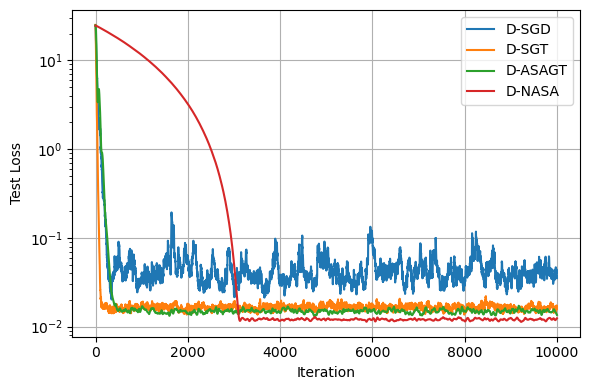

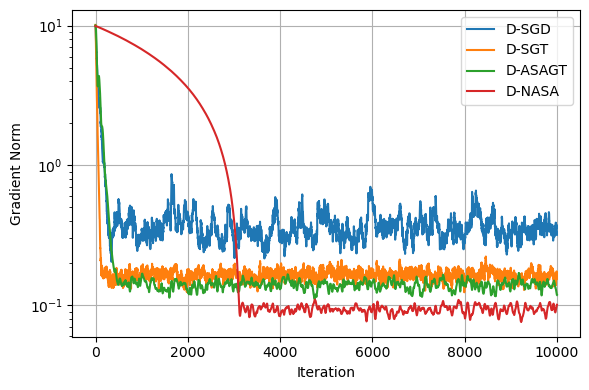

In [7]:
# linear speedup experiments for online setting
num_of_nodes = 10
loss_list_std = {}
gm_list_std = {}

x_init = torch.randn(size=(1,))

# problem parameters
dimension = 100
noise_rate = 0.1
network_topology = ['ring', 0.4]
# network_topology = ['complete', 1 / num_of_nodes]

c = 0
sparsity_ratio = 0.3
sparsity_num = int(dimension * sparsity_ratio)
# create a sparse ground truth beta
beta = torch.zeros(dimension)
indices = torch.randperm(dimension)[0: sparsity_num]
beta[indices] = torch.normal(mean=0, std=1, size=(sparsity_num, ))
total_iteration = 10000

method_dict = {"D-SGD": dsgd, "D-SGT": dsgt, "D-ASAGT": dasagt, "D-NASA": dnasa}

for name, algo in method_dict.items():

    loss_history, gm_history = algo(dimension, num_of_nodes, total_iteration, beta, x_init, network_topology)
        
    loss_list_std[name] = loss_history
    gm_list_std[name] = gm_history

fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
plt.xlabel('Iteration')
ax.set_ylabel('Test Loss')
ax.set_yscale('log')
for name, loss_curve in loss_list_std.items():
    plt.plot(loss_curve, label=name)
plt.legend()
plt.grid()
plt.savefig("plots/synthetic_std_model_loss_constant.pdf")
plt.show()


fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
plt.xlabel('Iteration')
ax.set_ylabel('Gradient Norm')
ax.set_yscale('log')
for name, gm in gm_list_std.items():
    plt.plot(gm, label=name)
plt.legend()
plt.grid()
plt.savefig("plots/synthetic_std_model_norm_constant.pdf")
plt.show()

In [18]:
# linear speedup experiments for online setting
num_of_nodes=10
loss_list_std = {}
gm_list_std = {}

x_init = torch.randn(size=(1,))

# problem parameters
dimension = 100
noise_rate = 0.1
network_topology = ['ring', 0.4]
# network_topology = ['complete', 1 / num_of_nodes]

c = 0
sparsity_ratio = 0.3
sparsity_num = int(dimension * sparsity_ratio)
# create a sparse ground truth beta
beta = torch.zeros(dimension)
indices = torch.randperm(dimension)[0: sparsity_num]
beta[indices] = torch.normal(mean=0, std=1, size=(sparsity_num, ))
total_iteration = 10000

method_dict = {"D-SGD": dsgd, "D-SGT": dsgt, "D-ASAGT": dasagt, "D-NASA": dnasa}
lr_dict = {"D-SGD": 1e-2, "D-SGT": 1e-2, "D-ASAGT": 1e-2, "D-NASA": 1}

for name, algo in method_dict.items():
    
    loss_history, gm_history = algo(dimension, num_of_nodes, total_iteration, beta, x_init, network_topology, gamma0=lr_dict[name], step_type="diminishing")

    loss_list_std[name] = loss_history
    gm_list_std[name] = gm_history

test D-NASA on ['ring', 0.4], rho=0.8854104280471802, total iter 10000
test D-SGT on ['ring', 0.4], rho=0.8854104280471802, total iter 10000
test D-ASAGT on ['ring', 0.4], rho=0.8854104280471802, total iter 10000
test D-NASA on ['ring', 0.4], rho=0.8854104280471802, total iter 10000


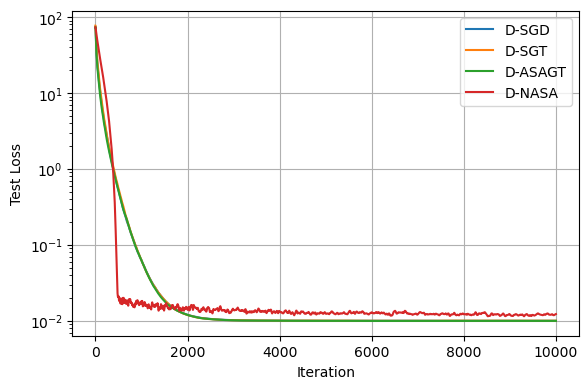

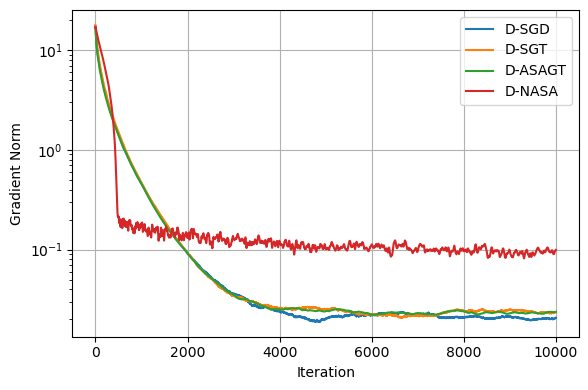

In [19]:
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
plt.xlabel('Iteration')
ax.set_ylabel('Test Loss')
ax.set_yscale('log')
for name, loss_curve in loss_list_std.items():
    plt.plot(loss_curve, label=name)
plt.legend()
plt.grid()
plt.savefig("plots/synthetic_std_model_loss_diminishing.pdf")
plt.show()


fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
plt.xlabel('Iteration')
ax.set_ylabel('Gradient Norm')
ax.set_yscale('log')
for name, gm in gm_list_std.items():
    plt.plot(gm, label=name)
plt.legend()
plt.grid()
plt.savefig("plots/synthetic_std_model_norm_diminishing.pdf")
plt.show()

In [12]:
# linear speedup experiments for online setting
num_of_nodes=10
loss_list_std = {}
gm_list_std = {}

x_init = torch.randn(size=(1,))

# problem parameters
dimension = 100
noise_rate = 0.1
network_topology = ['ring', 0.4]
# network_topology = ['complete', 1 / num_of_nodes]

c = 0
sparsity_ratio = 0.3
sparsity_num = int(dimension * sparsity_ratio)
# create a sparse ground truth beta
beta = torch.zeros(dimension)
indices = torch.randperm(dimension)[0: sparsity_num]
beta[indices] = torch.normal(mean=0, std=1, size=(sparsity_num, ))
total_iteration = 10000

method_dict = {"D-SGD": dsgd, "D-SGT": dsgt, "D-ASAGT": dasagt, "D-NASA": dnasa}
lr_dict = {"D-SGD": 1e-4, "D-SGT": 1e-4, "D-ASAGT": 1e-4, "D-NASA": 1}

total_trial = 1
for trial in range(total_trial):
    print(f"trial {trial}")
    for name, algo in method_dict.items():
        
        loss_history, gm_history = algo(dimension, num_of_nodes, total_iteration, beta, x_init, network_topology, gamma0=lr_dict[name], mode="spike", step_type="diminishing")

        if trial == 0:
            loss_list_std[name] = loss_history
            gm_list_std[name] = gm_history
        else:
            loss_list_std[name] = loss_list_std[name] + loss_history
            gm_list_std[name] = gm_list_std[name] + gm_history

for name, algo in method_dict.items():
    loss_list_std[name] = loss_list_std[name] / total_trial
    gm_list_std[name] = gm_list_std[name] / total_trial

trial 0
test D-NASA on ['ring', 0.4], rho=0.8854104280471802, total iter 10000
test D-SGT on ['ring', 0.4], rho=0.8854104280471802, total iter 10000
test D-ASAGT on ['ring', 0.4], rho=0.8854104280471802, total iter 10000
test D-NASA on ['ring', 0.4], rho=0.8854104280471802, total iter 10000


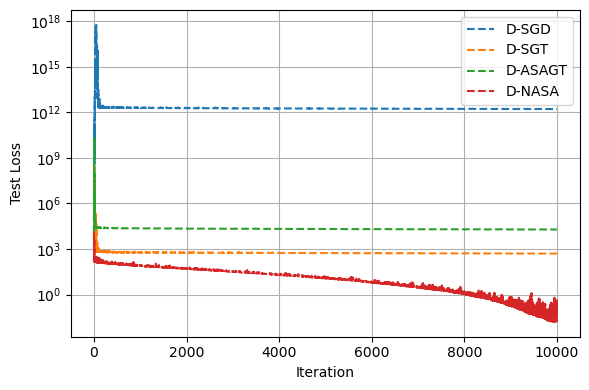

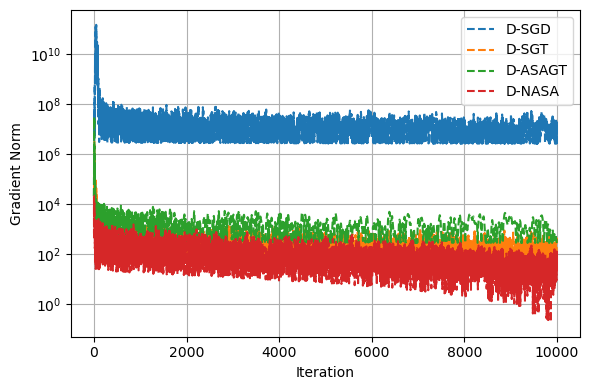

In [13]:
fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
plt.xlabel('Iteration')
ax.set_ylabel('Test Loss')
ax.set_yscale('log')
for name, loss_curve in loss_list_std.items():
    plt.plot(loss_curve, label=name, linestyle = '--')
plt.legend()
plt.grid()
plt.savefig("plots/synthetic_spike_model_loss_diminishing.pdf")
plt.show()

fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
plt.xlabel('Iteration')
ax.set_ylabel('Gradient Norm')
ax.set_yscale('log')
for name, gm in gm_list_std.items():
    plt.plot(gm, label=name, linestyle = '--')
plt.legend()
plt.grid()
plt.savefig("plots/synthetic_spike_model_norm_diminishing.pdf")
plt.show()